### Get the data from Dropbox


In [ ]:
!wget https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip

--2024-09-26 20:17:17--  https://www.dropbox.com/s/si11cws2pyho1bp/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap [following]
--2024-09-26 20:17:18--  https://www.dropbox.com/scl/fi/x9eaye2fanuc005ucprmq/archive.zip?rlkey=fawlx24mxtnicc8f65kd5ufap
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb5afe2f1b8a5ac2e25b05f84df.dl.dropboxusercontent.com/cd/0/inline/CbW02tq7qUqNY6SEDc7bkR-Iyjc6YLjqTJeRa7swj1fMn3f8C9rZ7TqH9Ulmg9rhW0Lm2jXaRI58MhIWhK6WU3KThrPrFdIdU2cgeQrRrdYFiANlYtfGqT6A1ASo4FJF5eGBEub_PU_xk-QpBoQBFrZA/file# [following]
--2024-09-26 20:17:19--  https://ucb5afe2f1b8a5ac2e25b05f84df.dl.dropboxusercontent.com/cd/0/inline/Cb

In [ ]:
!unzip -q "/content/archive.zip"

### Imports required for this project


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

### Creating the Pathlib PATH objects

In [ ]:

train_path = Path("/content/train")
test_path = Path("/content/test")

###  Applying Data Augmentation to the training data

In [ ]:


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data Augmentation for Training data to avoid overfitting
train_datagen = ImageDataGenerator(
    rescale=1./255,           # Rescale pixel values between 0 and 1
    rotation_range=20,        # Random rotation
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shearing
    zoom_range=0.2,           # Zooming
    horizontal_flip=True,     # Horizontal flip
    fill_mode='nearest'       # Fill mode
)

# No augmentation for the validation and test data, only rescaling
valid_datagen = ImageDataGenerator(rescale=1./255)

# Creating Data Generators for Train, Validation and Test
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_directory(
    test_path,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)


Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


### Building a CNN model with dropout and regularization to avoid overfitting


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Determine the number of classes based on your dataset (replace 7 with actual number if different)
num_classes = 7

# Model architecture
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  # Dropout to avoid overfitting

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # L2 Regularization
    Dropout(0.5),
    Dense(num_classes, activation='softmax')  # Updated number of classes
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Model training with early stopping
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // valid_generator.batch_size,
    epochs=50,
    callbacks=[early_stopping]  # Using early stopping
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


897/897 ━━━━━━━━━━━━━━━━━━━━ 188s 199ms/step - accuracy: 0.2324 - loss: 2.1192 - val_accuracy: 0.2469 - val_loss: 1.8171
Epoch 2/50
  1/897 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - accuracy: 0.2500 - loss: 1.7784

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


897/897 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2500 - loss: 1.7784 - val_accuracy: 0.4000 - val_loss: 2.1643
Epoch 3/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 189s 192ms/step - accuracy: 0.2535 - loss: 1.8197 - val_accuracy: 0.2468 - val_loss: 1.8021
Epoch 4/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 76us/step - accuracy: 0.1250 - loss: 1.9423 - val_accuracy: 0.5000 - val_loss: 1.6510
Epoch 5/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 175s 193ms/step - accuracy: 0.2494 - loss: 1.8136 - val_accuracy: 0.2485 - val_loss: 1.8007
Epoch 6/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.1250 - loss: 1.8239 - val_accuracy: 0.2000 - val_loss: 1.7815
Epoch 7/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 172s 190ms/step - accuracy: 0.2537 - loss: 1.8110 - val_accuracy: 0.2469 - val_loss: 1.8006
Epoch 8/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 0s 22us/step - accuracy: 0.1875 - loss: 1.8553 - val_accuracy: 0.3000 - val_loss: 1.7156
Epoch 9/50
897/897 ━━━━━━━━━━━━━━━━━━━━ 172s 190ms/step - accuracy: 0.2525 - loss: 1.8131 - val_accur

### Getting Image paths


In [ ]:
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x : str(x) , train_image_paths))

train_image_paths[:10]

['/content/train/angry/Training_94952701.jpg',
 '/content/train/angry/Training_84701834.jpg',
 '/content/train/angry/Training_78323011.jpg',
 '/content/train/angry/Training_86431040.jpg',
 '/content/train/angry/Training_91558476.jpg',
 '/content/train/angry/Training_43270328.jpg',
 '/content/train/angry/Training_90610607.jpg',
 '/content/train/angry/Training_70972934.jpg',
 '/content/train/angry/Training_28667373.jpg',
 '/content/train/angry/Training_89114103.jpg']

### Getting their respective labels



In [ ]:

def get_label(image_path):
    return image_path.split("/")[-2]

train_image_labels = list(map(lambda x : get_label(x) , train_image_paths))
train_image_labels[:10]

['angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry',
 'angry']

### Apply label encoder

In [ ]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

train_image_labels[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

train_image_labels[:10]

array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.]])

### split the data

In [ ]:
from sklearn.model_selection import train_test_split

Train_paths , Val_paths , Train_labels , Val_labels = train_test_split(train_image_paths , train_image_labels , test_size = 0.25)

### Compute class weights
#### where the goal is to assign higher weights to underrepresented classes to help balance the model's training

In [ ]:
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

class_weight = {e : weight for e , weight in enumerate(classWeight)}
print(class_weight)

{0: 1.7913477537437603, 1: 15.83235294117647, 2: 1.7494312642183945, 3: 1.0, 4: 1.4404602622424405, 5: 1.4936182019977802, 6: 2.2570230607966457}


### Function used for Transformation


In [ ]:
def load(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)#This decodes the binary JPEG string into a 3-channel (RGB) image tensor.
    return image , label

### Define IMAGE SIZE and BATCH SIZE


In [ ]:
IMG_SIZE = 96
BATCH_SIZE = 32

# Basic Transformation
resize = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE)
])

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(height_factor = (-0.1, -0.05))
])

### Function used to Create a Tensorflow Data Object


In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
def get_dataset(paths , labels , train = True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset , label_dataset))

    dataset = dataset.map(lambda image , label : load(image , label))
    dataset = dataset.map(lambda image, label: (resize(image), label) , num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
        dataset = dataset.map(lambda image, label: (data_augmentation(image), label) , num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

### Creating Train Dataset object and Verifying it


In [ ]:
%time train_dataset = get_dataset(Train_paths , Train_labels)

image , label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 266 ms, sys: 7.01 ms, total: 273 ms
Wall time: 266 ms
(32, 96, 96, 3)
(32, 7)


### View a sample Training Image


fear


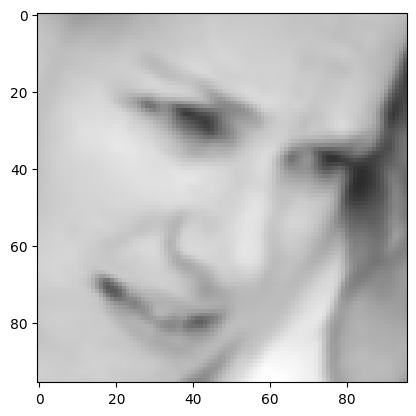

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

In [ ]:
%time val_dataset = get_dataset(Val_paths , Val_labels , train = False)

image , label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 43.5 ms, sys: 0 ns, total: 43.5 ms
Wall time: 46.9 ms
(32, 96, 96, 3)
(32, 7)


angry


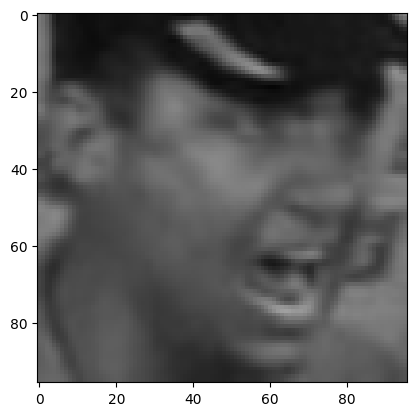

In [ ]:
print(Le.inverse_transform(np.argmax(label , axis = 1))[0])
plt.imshow((image[0].numpy()/255).reshape(96 , 96 , 3))

### Building EfficientNet model


In [ ]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape=(96, 96, 3),
    include_top=False # Set include_top to False to remove the classification layers
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

# Add a dummy input layer to define the input shape for the model
input_layer = tf.keras.layers.Input(shape=(96, 96, 3))
output = model(input_layer)

model.summary() # Now the model summary should work

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,949,824 (30.33 MB)

 Trainable params: 7,882,249 (30.07 MB)

 Non-trainable params: 67,575 (263.97 KB)

### Compiling your model by providing the Optimizer , Loss and Metrics


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

### Train the model


In [ ]:
history = model.fit(
    train_dataset,
    steps_per_epoch=len(Train_paths)//BATCH_SIZE,
    epochs=70,
    validation_data=val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight=class_weight
)

Epoch 1/70
672/672 ━━━━━━━━━━━━━━━━━━━━ 179s 100ms/step - accuracy: 0.3295 - loss: 3.0708 - precision: 0.5621 - recall: 0.1151 - val_accuracy: 0.5204 - val_loss: 1.3274 - val_precision: 0.6397 - val_recall: 0.3996
Epoch 2/70
672/672 ━━━━━━━━━━━━━━━━━━━━ 126s 97ms/step - accuracy: 0.4872 - loss: 2.4062 - precision: 0.6995 - recall: 0.2813 - val_accuracy: 0.5379 - val_loss: 1.2269 - val_precision: 0.7314 - val_recall: 0.3426
Epoch 3/70
672/672 ━━━━━━━━━━━━━━━━━━━━ 57s 85ms/step - accuracy: 0.5292 - loss: 2.2248 - precision: 0.7024 - recall: 0.3312 - val_accuracy: 0.5227 - val_loss: 1.3344 - val_precision: 0.6359 - val_recall: 0.3438
Epoch 4/70
672/672 ━━━━━━━━━━━━━━━━━━━━ 58s 87ms/step - accuracy: 0.5349 - loss: 2.1528 - precision: 0.6995 - recall: 0.3472 - val_accuracy: 0.5630 - val_loss: 1.1939 - val_precision: 0.7120 - val_recall: 0.3872
Epoch 5/70
672/672 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.5612 - loss: 2.0268 - precision: 0.7135 - recall: 0.3781 - val_accuracy: 0.5806 -

In [ ]:
model.layers[0].trainable = False

In [ ]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 3, 3, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1408)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 1408)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         180,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,714,324 (90.46 MB)

 Trainable params: 181,255 (708.03 KB)

 Non-trainable params: 7,768,569 (29.63 MB)

 Optimizer params: 15,764,500 (60.14 MB)

### Save model to h5

In [ ]:
model.save('my_model.h5')

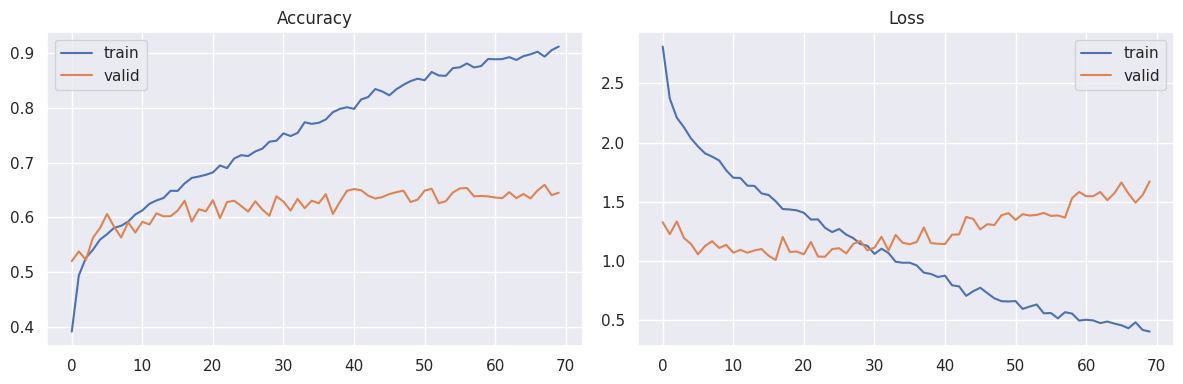

In [ ]:
import seaborn as sns
import matplotlib.pyplot as pyplot

sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
#The data is being passed as a dictionary to the data argument
sns.lineplot(x=history.epoch, y=history.history['accuracy'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
#The data is being passed as a dictionary to the data argument
sns.lineplot(x=history.epoch, y=history.history['loss'], label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], label='valid')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()